In [1]:
import re
import numpy as np
from tqdm import tqdm, trange
import torch
from nltk.corpus import stopwords
import pandas as pd

In [2]:
stop_words = set(stopwords.words('english'))

In [3]:
data = ""
PATH = "/kaggle/input/word2vec-toy-dataset/wiki.txt"
with open(PATH, "r") as f:
  data = f.read()

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cuda', index=0)

In [6]:
def tokenize(text):
    pattern = re.compile(r"[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*")
    return pattern.findall(text.lower())


def vocabulary(list_of_words: list[str]):
    vocab = set(list_of_words)
    indices = [i for i in range(len(vocab))]
    return len(vocab), dict(zip(vocab, indices))


def one_hot_vector(vocab: dict, word: str):
    vector = [0 for _ in range(len(vocab.keys()))]
    word_index = vocab.get(word, 0)
    vector[word_index] = 1
    return vector


def generate_training_data(token: str, vocab: dict, window_size: int):
    X = []
    y = []
    for i in range(len(token)):
        indices = get_indices_by_window(i, window_size, len(token))
        for index in indices:
            X.append(one_hot_vector(vocab, token[i]))
            y.append(one_hot_vector(vocab, token[index]))

    return torch.DoubleTensor(X).cuda(), torch.DoubleTensor(y).cuda()


def get_indices_by_window(curr_index: int, window_size: int, limit: int):
    pre_indices = [k for k in range(curr_index - window_size, curr_index)]
    post_indices = [
        k for k in range(curr_index + 1, curr_index + window_size + 1)
    ]
    
    raw_indices = pre_indices + post_indices

    indices = []

    for index in raw_indices:
        if 0 <= index < limit:
            indices.append(index)

    return indices

def convert_prob_dist_to_word(prob: np.array, words: dict):
    word_index = np.argmax(prob)
    return words[word_index]

def convert_prob_dist_to_one_hot_vector(prob: np.array, words: list[str]):
    vector = [0 for _ in range(len(words))]
    word_index = np.argmax(prob)
    vector[word_index] = 1
    return vector

def convert_id_to_word(vocab):
    indices = {}
    for i, word in enumerate(vocab.keys()):
        indices[vocab[word]] = word
    return indices

In [7]:
class SkipGram:
    def __init__(self, n_dims: int = 300):
        self.n_dims = n_dims
        self.W1 = torch.rand((vocab_size, n_dims)).cuda().type(torch.cuda.DoubleTensor)
        self.W2 = torch.rand((n_dims, vocab_size)).cuda().type(torch.cuda.DoubleTensor)

    def softmax(self, z):
        return torch.softmax(z, dim=1)

    def forward(self, X):
        input_embedding = X @ self.W1
        output_embedding = input_embedding @ self.W2
    
        return [
            input_embedding,
            output_embedding,
            self.softmax(output_embedding),
        ]

    def backward(self, X, y):
        a1, a2, predict = self.forward(X)
        da2 = predict - y
        dw2 = a1.T @ da2
        dw1 = X.T @ da2 @ self.W2.T / X.shape[0]
        return dw1, dw2
    
    def loss(self, y_hat, y):
        return 1/2 * ((y_hat - y) ** 2).sum()

    def gradient_descent(self, lr, dw1, dw2):
        self.W1 -= lr * dw1
        self.W2 -= lr * dw2
    
    def split_data(self, X, y, batch_size: int):
        k = 0
        X_batch = []
        y_batch = []

        for i in range(0, X.shape[0], batch_size):
            X_batch.append(X[k : k + batch_size + 1])
            y_batch.append(y[k : k + batch_size + 1])
            k += batch_size
        
        if k < X.shape[0]:
            X_batch.append(X[k - batch_size::])
            y_batch.append(y[k - batch_size::])
        
        return X_batch, y_batch

    def fit(self, X, y, epochs: int, learning_rate: float, batch_size: int):
        history = {}
        X_batch, y_batch = self.split_data(X, y, batch_size)
        for i in range(epochs):
            print(f"Epoch {i + 1}/{epochs}: ", end="")
            loss_per_batch = 0
            for j in trange(len(X_batch)):
                _, _, predict = self.forward(X_batch[j])
                loss_per_batch += self.loss(predict, y_batch[j]) / len(X_batch)
                dw1, dw2 = self.backward(X_batch[j], y_batch[j])
                self.gradient_descent(learning_rate, dw1, dw2)
            history[i] = loss_per_batch
            print(f"\t loss: {loss_per_batch}")
        return history

    def crossentropy(self, p, q):
        return -torch.sum(torch.log(p) * q)
    
    def save(self, path: str):
        model = {
            "W1" : self.W1,
            "W2" : self.W2
        }
        
        torch.save(model, path)

words = tokenize(data)
words = [word for word in words if word not in stop_words]
vocab_size, vocabularies = vocabulary(words)

In [8]:
len(words)

5022

In [9]:
window_size = 10
X, y = generate_training_data(words, vocabularies, window_size)

In [10]:
indices = torch.randperm(X.size()[0])
X_train = X[indices]
y_train = y[indices]

In [11]:
print(X.shape, y.shape)

torch.Size([100330, 1828]) torch.Size([100330, 1828])


In [12]:
n_dims = 300
EPOCHS = 500
LR = 5e-2
BATCH_SIZE = 1024

model = SkipGram(n_dims)
history = model.fit(X_train, y_train, EPOCHS, LR, BATCH_SIZE)

Epoch 1/500: 

100%|██████████| 98/98 [00:01<00:00, 49.51it/s]


	 loss: 901.2954834602997
Epoch 2/500: 

100%|██████████| 98/98 [00:00<00:00, 431.84it/s]


	 loss: 805.0127805051678
Epoch 3/500: 

100%|██████████| 98/98 [00:00<00:00, 432.46it/s]


	 loss: 740.7287214312821
Epoch 4/500: 

100%|██████████| 98/98 [00:00<00:00, 432.33it/s]


	 loss: 688.5646494277246
Epoch 5/500: 

100%|██████████| 98/98 [00:00<00:00, 432.62it/s]


	 loss: 686.4191606163755
Epoch 6/500: 

100%|██████████| 98/98 [00:00<00:00, 433.86it/s]


	 loss: 669.6066689136028
Epoch 7/500: 

100%|██████████| 98/98 [00:00<00:00, 433.22it/s]


	 loss: 681.5298662217
Epoch 8/500: 

100%|██████████| 98/98 [00:00<00:00, 434.85it/s]


	 loss: 658.2915629482942
Epoch 9/500: 

100%|██████████| 98/98 [00:00<00:00, 435.68it/s]


	 loss: 667.5215682936318
Epoch 10/500: 

100%|██████████| 98/98 [00:00<00:00, 435.18it/s]


	 loss: 655.5261327620306
Epoch 11/500: 

100%|██████████| 98/98 [00:00<00:00, 435.36it/s]


	 loss: 660.4037799345805
Epoch 12/500: 

100%|██████████| 98/98 [00:00<00:00, 435.03it/s]


	 loss: 657.6268153371385
Epoch 13/500: 

100%|██████████| 98/98 [00:00<00:00, 436.14it/s]


	 loss: 658.1663850866506
Epoch 14/500: 

100%|██████████| 98/98 [00:00<00:00, 436.45it/s]


	 loss: 652.8422736775534
Epoch 15/500: 

100%|██████████| 98/98 [00:00<00:00, 436.38it/s]


	 loss: 649.8755734208694
Epoch 16/500: 

100%|██████████| 98/98 [00:00<00:00, 435.68it/s]


	 loss: 651.9387850264259
Epoch 17/500: 

100%|██████████| 98/98 [00:00<00:00, 436.27it/s]


	 loss: 645.9637886446754
Epoch 18/500: 

100%|██████████| 98/98 [00:00<00:00, 435.98it/s]


	 loss: 646.0695596759629
Epoch 19/500: 

100%|██████████| 98/98 [00:00<00:00, 436.38it/s]


	 loss: 646.9288190902465
Epoch 20/500: 

100%|██████████| 98/98 [00:00<00:00, 436.78it/s]


	 loss: 642.1243080856393
Epoch 21/500: 

100%|██████████| 98/98 [00:00<00:00, 436.76it/s]


	 loss: 643.3999498375506
Epoch 22/500: 

100%|██████████| 98/98 [00:00<00:00, 436.53it/s]


	 loss: 637.8406966976772
Epoch 23/500: 

100%|██████████| 98/98 [00:00<00:00, 436.53it/s]


	 loss: 638.8350769032185
Epoch 24/500: 

100%|██████████| 98/98 [00:00<00:00, 436.69it/s]


	 loss: 641.6693433004322
Epoch 25/500: 

100%|██████████| 98/98 [00:00<00:00, 436.29it/s]


	 loss: 646.7438787399437
Epoch 26/500: 

100%|██████████| 98/98 [00:00<00:00, 436.44it/s]


	 loss: 623.9564777971901
Epoch 27/500: 

100%|██████████| 98/98 [00:00<00:00, 436.32it/s]


	 loss: 638.2089441344798
Epoch 28/500: 

100%|██████████| 98/98 [00:00<00:00, 436.66it/s]


	 loss: 630.9767650898523
Epoch 29/500: 

100%|██████████| 98/98 [00:00<00:00, 436.14it/s]


	 loss: 628.9277400958823
Epoch 30/500: 

100%|██████████| 98/98 [00:00<00:00, 436.68it/s]


	 loss: 632.2188774733182
Epoch 31/500: 

100%|██████████| 98/98 [00:00<00:00, 436.45it/s]


	 loss: 631.4026798733763
Epoch 32/500: 

100%|██████████| 98/98 [00:00<00:00, 436.55it/s]


	 loss: 631.4160025541188
Epoch 33/500: 

100%|██████████| 98/98 [00:00<00:00, 436.64it/s]


	 loss: 625.4924526116764
Epoch 34/500: 

100%|██████████| 98/98 [00:00<00:00, 436.80it/s]


	 loss: 627.1144937013121
Epoch 35/500: 

100%|██████████| 98/98 [00:00<00:00, 436.52it/s]


	 loss: 622.5227842742912
Epoch 36/500: 

100%|██████████| 98/98 [00:00<00:00, 436.71it/s]


	 loss: 629.9166417922911
Epoch 37/500: 

100%|██████████| 98/98 [00:00<00:00, 436.04it/s]


	 loss: 625.0412445051518
Epoch 38/500: 

100%|██████████| 98/98 [00:00<00:00, 436.68it/s]


	 loss: 623.2863019766291
Epoch 39/500: 

100%|██████████| 98/98 [00:00<00:00, 436.03it/s]


	 loss: 622.1206611775424
Epoch 40/500: 

100%|██████████| 98/98 [00:00<00:00, 436.77it/s]


	 loss: 622.4505515709036
Epoch 41/500: 

100%|██████████| 98/98 [00:00<00:00, 436.67it/s]


	 loss: 623.7349299786199
Epoch 42/500: 

100%|██████████| 98/98 [00:00<00:00, 437.04it/s]


	 loss: 620.7382087395192
Epoch 43/500: 

100%|██████████| 98/98 [00:00<00:00, 437.10it/s]


	 loss: 622.9368179800902
Epoch 44/500: 

100%|██████████| 98/98 [00:00<00:00, 435.90it/s]


	 loss: 620.0919240877324
Epoch 45/500: 

100%|██████████| 98/98 [00:00<00:00, 436.43it/s]


	 loss: 617.8996040055445
Epoch 46/500: 

100%|██████████| 98/98 [00:00<00:00, 436.75it/s]


	 loss: 619.7542642701809
Epoch 47/500: 

100%|██████████| 98/98 [00:00<00:00, 436.79it/s]


	 loss: 617.1084379121085
Epoch 48/500: 

100%|██████████| 98/98 [00:00<00:00, 436.85it/s]


	 loss: 616.8767888585145
Epoch 49/500: 

100%|██████████| 98/98 [00:00<00:00, 436.94it/s]


	 loss: 616.4278878732312
Epoch 50/500: 

100%|██████████| 98/98 [00:00<00:00, 435.98it/s]


	 loss: 619.1715165756934
Epoch 51/500: 

100%|██████████| 98/98 [00:00<00:00, 436.81it/s]


	 loss: 613.2152226568031
Epoch 52/500: 

100%|██████████| 98/98 [00:00<00:00, 435.14it/s]


	 loss: 614.5714901903889
Epoch 53/500: 

100%|██████████| 98/98 [00:00<00:00, 435.85it/s]


	 loss: 617.2034328864132
Epoch 54/500: 

100%|██████████| 98/98 [00:00<00:00, 436.01it/s]


	 loss: 611.877079993056
Epoch 55/500: 

100%|██████████| 98/98 [00:00<00:00, 436.88it/s]


	 loss: 613.6978163218077
Epoch 56/500: 

100%|██████████| 98/98 [00:00<00:00, 436.47it/s]


	 loss: 616.8088067588849
Epoch 57/500: 

100%|██████████| 98/98 [00:00<00:00, 436.50it/s]


	 loss: 611.7840307108546
Epoch 58/500: 

100%|██████████| 98/98 [00:00<00:00, 437.02it/s]


	 loss: 610.3326252363836
Epoch 59/500: 

100%|██████████| 98/98 [00:00<00:00, 436.43it/s]


	 loss: 610.6884315416169
Epoch 60/500: 

100%|██████████| 98/98 [00:00<00:00, 436.08it/s]


	 loss: 611.1554295464366
Epoch 61/500: 

100%|██████████| 98/98 [00:00<00:00, 436.94it/s]


	 loss: 609.7583904901909
Epoch 62/500: 

100%|██████████| 98/98 [00:00<00:00, 436.86it/s]


	 loss: 609.5547477936259
Epoch 63/500: 

100%|██████████| 98/98 [00:00<00:00, 436.62it/s]


	 loss: 608.6806512009834
Epoch 64/500: 

100%|██████████| 98/98 [00:00<00:00, 435.71it/s]


	 loss: 611.1326932107593
Epoch 65/500: 

100%|██████████| 98/98 [00:00<00:00, 436.78it/s]


	 loss: 606.8191215097676
Epoch 66/500: 

100%|██████████| 98/98 [00:00<00:00, 437.11it/s]


	 loss: 609.396721962438
Epoch 67/500: 

100%|██████████| 98/98 [00:00<00:00, 436.70it/s]


	 loss: 608.8883758385642
Epoch 68/500: 

100%|██████████| 98/98 [00:00<00:00, 436.81it/s]


	 loss: 604.562225932419
Epoch 69/500: 

100%|██████████| 98/98 [00:00<00:00, 436.79it/s]


	 loss: 605.6176738938998
Epoch 70/500: 

100%|██████████| 98/98 [00:00<00:00, 436.68it/s]


	 loss: 605.977254895392
Epoch 71/500: 

100%|██████████| 98/98 [00:00<00:00, 436.70it/s]


	 loss: 609.4041973939344
Epoch 72/500: 

100%|██████████| 98/98 [00:00<00:00, 436.97it/s]


	 loss: 606.5927186130598
Epoch 73/500: 

100%|██████████| 98/98 [00:00<00:00, 436.88it/s]


	 loss: 606.0303916548081
Epoch 74/500: 

100%|██████████| 98/98 [00:00<00:00, 436.45it/s]


	 loss: 605.3525048719816
Epoch 75/500: 

100%|██████████| 98/98 [00:00<00:00, 437.03it/s]


	 loss: 602.8975903805618
Epoch 76/500: 

100%|██████████| 98/98 [00:00<00:00, 436.85it/s]


	 loss: 605.6334685627713
Epoch 77/500: 

100%|██████████| 98/98 [00:00<00:00, 436.67it/s]


	 loss: 606.0983689892965
Epoch 78/500: 

100%|██████████| 98/98 [00:00<00:00, 436.36it/s]


	 loss: 602.6106352872071
Epoch 79/500: 

100%|██████████| 98/98 [00:00<00:00, 437.01it/s]


	 loss: 600.8744017021365
Epoch 80/500: 

100%|██████████| 98/98 [00:00<00:00, 436.42it/s]


	 loss: 604.1180308739048
Epoch 81/500: 

100%|██████████| 98/98 [00:00<00:00, 436.64it/s]


	 loss: 604.767548101744
Epoch 82/500: 

100%|██████████| 98/98 [00:00<00:00, 436.76it/s]


	 loss: 597.9845605142733
Epoch 83/500: 

100%|██████████| 98/98 [00:00<00:00, 436.36it/s]


	 loss: 601.3768606996495
Epoch 84/500: 

100%|██████████| 98/98 [00:00<00:00, 435.99it/s]


	 loss: 602.2097213960274
Epoch 85/500: 

100%|██████████| 98/98 [00:00<00:00, 435.81it/s]


	 loss: 600.4785154359557
Epoch 86/500: 

100%|██████████| 98/98 [00:00<00:00, 435.73it/s]


	 loss: 597.7559128429518
Epoch 87/500: 

100%|██████████| 98/98 [00:00<00:00, 436.82it/s]


	 loss: 604.246832183222
Epoch 88/500: 

100%|██████████| 98/98 [00:00<00:00, 436.61it/s]


	 loss: 598.2568446957013
Epoch 89/500: 

100%|██████████| 98/98 [00:00<00:00, 437.09it/s]


	 loss: 600.2157414435123
Epoch 90/500: 

100%|██████████| 98/98 [00:00<00:00, 436.29it/s]


	 loss: 598.7353582507124
Epoch 91/500: 

100%|██████████| 98/98 [00:00<00:00, 436.60it/s]


	 loss: 598.4198312436258
Epoch 92/500: 

100%|██████████| 98/98 [00:00<00:00, 437.02it/s]


	 loss: 602.2836569977338
Epoch 93/500: 

100%|██████████| 98/98 [00:00<00:00, 437.08it/s]


	 loss: 597.052439866095
Epoch 94/500: 

100%|██████████| 98/98 [00:00<00:00, 436.43it/s]


	 loss: 598.2868162419812
Epoch 95/500: 

100%|██████████| 98/98 [00:00<00:00, 436.38it/s]


	 loss: 594.9476085255268
Epoch 96/500: 

100%|██████████| 98/98 [00:00<00:00, 436.56it/s]


	 loss: 598.808705918857
Epoch 97/500: 

100%|██████████| 98/98 [00:00<00:00, 437.01it/s]


	 loss: 598.6671777545685
Epoch 98/500: 

100%|██████████| 98/98 [00:00<00:00, 436.39it/s]


	 loss: 596.9999748952719
Epoch 99/500: 

100%|██████████| 98/98 [00:00<00:00, 436.70it/s]


	 loss: 598.2678996079748
Epoch 100/500: 

100%|██████████| 98/98 [00:00<00:00, 436.97it/s]


	 loss: 595.6451703895799
Epoch 101/500: 

100%|██████████| 98/98 [00:00<00:00, 436.56it/s]


	 loss: 596.8087385932208
Epoch 102/500: 

100%|██████████| 98/98 [00:00<00:00, 436.55it/s]


	 loss: 596.3713140936559
Epoch 103/500: 

100%|██████████| 98/98 [00:00<00:00, 436.89it/s]


	 loss: 597.3440235429662
Epoch 104/500: 

100%|██████████| 98/98 [00:00<00:00, 434.59it/s]


	 loss: 595.7055119725779
Epoch 105/500: 

100%|██████████| 98/98 [00:00<00:00, 436.15it/s]


	 loss: 595.1078027531693
Epoch 106/500: 

100%|██████████| 98/98 [00:00<00:00, 436.89it/s]


	 loss: 594.8700076582587
Epoch 107/500: 

100%|██████████| 98/98 [00:00<00:00, 436.80it/s]


	 loss: 596.2705825696816
Epoch 108/500: 

100%|██████████| 98/98 [00:00<00:00, 436.55it/s]


	 loss: 593.6005872639086
Epoch 109/500: 

100%|██████████| 98/98 [00:00<00:00, 436.97it/s]


	 loss: 593.4554298523317
Epoch 110/500: 

100%|██████████| 98/98 [00:00<00:00, 436.64it/s]


	 loss: 592.330846566364
Epoch 111/500: 

100%|██████████| 98/98 [00:00<00:00, 436.43it/s]


	 loss: 595.2746958019449
Epoch 112/500: 

100%|██████████| 98/98 [00:00<00:00, 436.83it/s]


	 loss: 593.5191457089629
Epoch 113/500: 

100%|██████████| 98/98 [00:00<00:00, 436.68it/s]


	 loss: 591.6950244457471
Epoch 114/500: 

100%|██████████| 98/98 [00:00<00:00, 436.84it/s]


	 loss: 593.3001380360738
Epoch 115/500: 

100%|██████████| 98/98 [00:00<00:00, 436.72it/s]


	 loss: 592.4431045680315
Epoch 116/500: 

100%|██████████| 98/98 [00:00<00:00, 435.89it/s]


	 loss: 592.2339022741102
Epoch 117/500: 

100%|██████████| 98/98 [00:00<00:00, 436.85it/s]


	 loss: 593.476054887908
Epoch 118/500: 

100%|██████████| 98/98 [00:00<00:00, 436.74it/s]


	 loss: 592.568790147569
Epoch 119/500: 

100%|██████████| 98/98 [00:00<00:00, 436.86it/s]


	 loss: 591.6019735456005
Epoch 120/500: 

100%|██████████| 98/98 [00:00<00:00, 436.35it/s]


	 loss: 591.9350604577254
Epoch 121/500: 

100%|██████████| 98/98 [00:00<00:00, 436.55it/s]


	 loss: 591.4971201483614
Epoch 122/500: 

100%|██████████| 98/98 [00:00<00:00, 436.67it/s]


	 loss: 592.0306624530424
Epoch 123/500: 

100%|██████████| 98/98 [00:00<00:00, 436.14it/s]


	 loss: 590.24964173288
Epoch 124/500: 

100%|██████████| 98/98 [00:00<00:00, 436.03it/s]


	 loss: 589.7812508788336
Epoch 125/500: 

100%|██████████| 98/98 [00:00<00:00, 435.90it/s]


	 loss: 590.1131815314278
Epoch 126/500: 

100%|██████████| 98/98 [00:00<00:00, 436.82it/s]


	 loss: 591.2334716792938
Epoch 127/500: 

100%|██████████| 98/98 [00:00<00:00, 436.25it/s]


	 loss: 589.6241179338565
Epoch 128/500: 

100%|██████████| 98/98 [00:00<00:00, 436.68it/s]


	 loss: 588.3688193143425
Epoch 129/500: 

100%|██████████| 98/98 [00:00<00:00, 436.87it/s]


	 loss: 591.237373524439
Epoch 130/500: 

100%|██████████| 98/98 [00:00<00:00, 435.64it/s]


	 loss: 588.9783854022984
Epoch 131/500: 

100%|██████████| 98/98 [00:00<00:00, 436.93it/s]


	 loss: 591.4092175325617
Epoch 132/500: 

100%|██████████| 98/98 [00:00<00:00, 436.92it/s]


	 loss: 590.5398396306633
Epoch 133/500: 

100%|██████████| 98/98 [00:00<00:00, 436.70it/s]


	 loss: 588.388861919172
Epoch 134/500: 

100%|██████████| 98/98 [00:00<00:00, 436.46it/s]


	 loss: 585.7443028636626
Epoch 135/500: 

100%|██████████| 98/98 [00:00<00:00, 436.02it/s]


	 loss: 589.2755585150586
Epoch 136/500: 

100%|██████████| 98/98 [00:00<00:00, 437.11it/s]


	 loss: 589.3004427787042
Epoch 137/500: 

100%|██████████| 98/98 [00:00<00:00, 436.74it/s]


	 loss: 588.6055454036208
Epoch 138/500: 

100%|██████████| 98/98 [00:00<00:00, 436.99it/s]


	 loss: 587.2047033192971
Epoch 139/500: 

100%|██████████| 98/98 [00:00<00:00, 436.69it/s]


	 loss: 587.8040205772214
Epoch 140/500: 

100%|██████████| 98/98 [00:00<00:00, 436.71it/s]


	 loss: 587.4911286005922
Epoch 141/500: 

100%|██████████| 98/98 [00:00<00:00, 436.05it/s]


	 loss: 586.7299322272362
Epoch 142/500: 

100%|██████████| 98/98 [00:00<00:00, 436.54it/s]


	 loss: 588.5904154597786
Epoch 143/500: 

100%|██████████| 98/98 [00:00<00:00, 436.20it/s]


	 loss: 586.195003599438
Epoch 144/500: 

100%|██████████| 98/98 [00:00<00:00, 436.90it/s]


	 loss: 585.664420528933
Epoch 145/500: 

100%|██████████| 98/98 [00:00<00:00, 436.02it/s]


	 loss: 588.6181008825457
Epoch 146/500: 

100%|██████████| 98/98 [00:00<00:00, 436.95it/s]


	 loss: 587.8101941321497
Epoch 147/500: 

100%|██████████| 98/98 [00:00<00:00, 435.45it/s]


	 loss: 586.0537525628714
Epoch 148/500: 

100%|██████████| 98/98 [00:00<00:00, 436.79it/s]


	 loss: 585.9336971755661
Epoch 149/500: 

100%|██████████| 98/98 [00:00<00:00, 436.05it/s]


	 loss: 585.4878762361315
Epoch 150/500: 

100%|██████████| 98/98 [00:00<00:00, 436.84it/s]


	 loss: 584.8548136816313
Epoch 151/500: 

100%|██████████| 98/98 [00:00<00:00, 436.77it/s]


	 loss: 585.7787181448126
Epoch 152/500: 

100%|██████████| 98/98 [00:00<00:00, 436.85it/s]


	 loss: 584.5770372367145
Epoch 153/500: 

100%|██████████| 98/98 [00:00<00:00, 436.50it/s]


	 loss: 586.3200762956943
Epoch 154/500: 

100%|██████████| 98/98 [00:00<00:00, 436.79it/s]


	 loss: 583.1592592145206
Epoch 155/500: 

100%|██████████| 98/98 [00:00<00:00, 436.38it/s]


	 loss: 585.8058880278735
Epoch 156/500: 

100%|██████████| 98/98 [00:00<00:00, 436.30it/s]


	 loss: 582.9447776628401
Epoch 157/500: 

100%|██████████| 98/98 [00:00<00:00, 436.52it/s]


	 loss: 584.6139394123333
Epoch 158/500: 

100%|██████████| 98/98 [00:00<00:00, 436.78it/s]


	 loss: 585.3573635428171
Epoch 159/500: 

100%|██████████| 98/98 [00:00<00:00, 436.94it/s]


	 loss: 583.5296307134048
Epoch 160/500: 

100%|██████████| 98/98 [00:00<00:00, 436.17it/s]


	 loss: 584.8533468319504
Epoch 161/500: 

100%|██████████| 98/98 [00:00<00:00, 436.31it/s]


	 loss: 583.2546444741107
Epoch 162/500: 

100%|██████████| 98/98 [00:00<00:00, 436.23it/s]


	 loss: 583.4327815693806
Epoch 163/500: 

100%|██████████| 98/98 [00:00<00:00, 436.46it/s]


	 loss: 583.3224582481816
Epoch 164/500: 

100%|██████████| 98/98 [00:00<00:00, 436.63it/s]


	 loss: 584.9823196143112
Epoch 165/500: 

100%|██████████| 98/98 [00:00<00:00, 436.62it/s]


	 loss: 582.0880250944573
Epoch 166/500: 

100%|██████████| 98/98 [00:00<00:00, 436.39it/s]


	 loss: 584.3671172503796
Epoch 167/500: 

100%|██████████| 98/98 [00:00<00:00, 436.21it/s]


	 loss: 584.7499109818222
Epoch 168/500: 

100%|██████████| 98/98 [00:00<00:00, 436.71it/s]


	 loss: 582.7179716629162
Epoch 169/500: 

100%|██████████| 98/98 [00:00<00:00, 435.32it/s]


	 loss: 581.9502405321716
Epoch 170/500: 

100%|██████████| 98/98 [00:00<00:00, 436.38it/s]


	 loss: 585.2170887940819
Epoch 171/500: 

100%|██████████| 98/98 [00:00<00:00, 436.49it/s]


	 loss: 579.3770792757069
Epoch 172/500: 

100%|██████████| 98/98 [00:00<00:00, 436.45it/s]


	 loss: 582.3501222359836
Epoch 173/500: 

100%|██████████| 98/98 [00:00<00:00, 436.83it/s]


	 loss: 584.555515999343
Epoch 174/500: 

100%|██████████| 98/98 [00:00<00:00, 436.74it/s]


	 loss: 580.7242191978594
Epoch 175/500: 

100%|██████████| 98/98 [00:00<00:00, 436.03it/s]


	 loss: 583.7017325381822
Epoch 176/500: 

100%|██████████| 98/98 [00:00<00:00, 436.72it/s]


	 loss: 583.8673382285167
Epoch 177/500: 

100%|██████████| 98/98 [00:00<00:00, 437.18it/s]


	 loss: 581.9501603186425
Epoch 178/500: 

100%|██████████| 98/98 [00:00<00:00, 436.76it/s]


	 loss: 580.9748816350706
Epoch 179/500: 

100%|██████████| 98/98 [00:00<00:00, 436.73it/s]


	 loss: 581.9464323611082
Epoch 180/500: 

100%|██████████| 98/98 [00:00<00:00, 436.72it/s]


	 loss: 579.7077851417295
Epoch 181/500: 

100%|██████████| 98/98 [00:00<00:00, 436.54it/s]


	 loss: 582.7611120219469
Epoch 182/500: 

100%|██████████| 98/98 [00:00<00:00, 436.30it/s]


	 loss: 580.3486653115365
Epoch 183/500: 

100%|██████████| 98/98 [00:00<00:00, 436.69it/s]


	 loss: 581.5941467223304
Epoch 184/500: 

100%|██████████| 98/98 [00:00<00:00, 435.59it/s]


	 loss: 582.2379066197585
Epoch 185/500: 

100%|██████████| 98/98 [00:00<00:00, 435.74it/s]


	 loss: 581.812437759669
Epoch 186/500: 

100%|██████████| 98/98 [00:00<00:00, 436.70it/s]


	 loss: 579.3202619371308
Epoch 187/500: 

100%|██████████| 98/98 [00:00<00:00, 436.03it/s]


	 loss: 580.1865141549234
Epoch 188/500: 

100%|██████████| 98/98 [00:00<00:00, 436.51it/s]


	 loss: 579.600327943339
Epoch 189/500: 

100%|██████████| 98/98 [00:00<00:00, 436.84it/s]


	 loss: 580.9427170173361
Epoch 190/500: 

100%|██████████| 98/98 [00:00<00:00, 436.18it/s]


	 loss: 581.7487273652251
Epoch 191/500: 

100%|██████████| 98/98 [00:00<00:00, 436.96it/s]


	 loss: 579.8441535170061
Epoch 192/500: 

100%|██████████| 98/98 [00:00<00:00, 435.68it/s]


	 loss: 582.5086124179074
Epoch 193/500: 

100%|██████████| 98/98 [00:00<00:00, 435.89it/s]


	 loss: 578.8389363271565
Epoch 194/500: 

100%|██████████| 98/98 [00:00<00:00, 435.92it/s]


	 loss: 580.2782064253385
Epoch 195/500: 

100%|██████████| 98/98 [00:00<00:00, 437.18it/s]


	 loss: 579.8340088279821
Epoch 196/500: 

100%|██████████| 98/98 [00:00<00:00, 435.47it/s]


	 loss: 580.3773998638256
Epoch 197/500: 

100%|██████████| 98/98 [00:00<00:00, 436.91it/s]


	 loss: 578.9248548088293
Epoch 198/500: 

100%|██████████| 98/98 [00:00<00:00, 436.85it/s]


	 loss: 579.273788565787
Epoch 199/500: 

100%|██████████| 98/98 [00:00<00:00, 436.59it/s]


	 loss: 578.5558165960124
Epoch 200/500: 

100%|██████████| 98/98 [00:00<00:00, 435.87it/s]


	 loss: 578.3787523005288
Epoch 201/500: 

100%|██████████| 98/98 [00:00<00:00, 436.80it/s]


	 loss: 578.3743844654025
Epoch 202/500: 

100%|██████████| 98/98 [00:00<00:00, 437.00it/s]


	 loss: 581.7236448883817
Epoch 203/500: 

100%|██████████| 98/98 [00:00<00:00, 436.42it/s]


	 loss: 578.522667170197
Epoch 204/500: 

100%|██████████| 98/98 [00:00<00:00, 436.76it/s]


	 loss: 577.2925835432172
Epoch 205/500: 

100%|██████████| 98/98 [00:00<00:00, 436.23it/s]


	 loss: 578.9881456934783
Epoch 206/500: 

100%|██████████| 98/98 [00:00<00:00, 436.40it/s]


	 loss: 577.6543429872557
Epoch 207/500: 

100%|██████████| 98/98 [00:00<00:00, 436.30it/s]


	 loss: 580.2754932896886
Epoch 208/500: 

100%|██████████| 98/98 [00:00<00:00, 436.40it/s]


	 loss: 578.3901475870368
Epoch 209/500: 

100%|██████████| 98/98 [00:00<00:00, 436.50it/s]


	 loss: 577.2687472025099
Epoch 210/500: 

100%|██████████| 98/98 [00:00<00:00, 437.00it/s]


	 loss: 578.890282361655
Epoch 211/500: 

100%|██████████| 98/98 [00:00<00:00, 436.47it/s]


	 loss: 579.4995196855655
Epoch 212/500: 

100%|██████████| 98/98 [00:00<00:00, 436.75it/s]


	 loss: 576.2043168498878
Epoch 213/500: 

100%|██████████| 98/98 [00:00<00:00, 436.51it/s]


	 loss: 575.9161994250646
Epoch 214/500: 

100%|██████████| 98/98 [00:00<00:00, 436.82it/s]


	 loss: 577.453594639837
Epoch 215/500: 

100%|██████████| 98/98 [00:00<00:00, 436.04it/s]


	 loss: 575.5702642731618
Epoch 216/500: 

100%|██████████| 98/98 [00:00<00:00, 436.81it/s]


	 loss: 575.9720046285267
Epoch 217/500: 

100%|██████████| 98/98 [00:00<00:00, 436.35it/s]


	 loss: 578.212520172811
Epoch 218/500: 

100%|██████████| 98/98 [00:00<00:00, 436.75it/s]


	 loss: 576.8526286364804
Epoch 219/500: 

100%|██████████| 98/98 [00:00<00:00, 436.34it/s]


	 loss: 576.0705763541697
Epoch 220/500: 

100%|██████████| 98/98 [00:00<00:00, 436.46it/s]


	 loss: 575.8755796030557
Epoch 221/500: 

100%|██████████| 98/98 [00:00<00:00, 436.42it/s]


	 loss: 576.7538685016088
Epoch 222/500: 

100%|██████████| 98/98 [00:00<00:00, 436.34it/s]


	 loss: 576.2978543107777
Epoch 223/500: 

100%|██████████| 98/98 [00:00<00:00, 436.45it/s]


	 loss: 576.084961547689
Epoch 224/500: 

100%|██████████| 98/98 [00:00<00:00, 436.17it/s]


	 loss: 576.6838105001417
Epoch 225/500: 

100%|██████████| 98/98 [00:00<00:00, 436.02it/s]


	 loss: 576.8557432388747
Epoch 226/500: 

100%|██████████| 98/98 [00:00<00:00, 436.77it/s]


	 loss: 575.6985906398924
Epoch 227/500: 

100%|██████████| 98/98 [00:00<00:00, 435.87it/s]


	 loss: 575.1338458735095
Epoch 228/500: 

100%|██████████| 98/98 [00:00<00:00, 436.52it/s]


	 loss: 575.5726299772052
Epoch 229/500: 

100%|██████████| 98/98 [00:00<00:00, 436.95it/s]


	 loss: 575.6563317390409
Epoch 230/500: 

100%|██████████| 98/98 [00:00<00:00, 437.35it/s]


	 loss: 575.4203288277496
Epoch 231/500: 

100%|██████████| 98/98 [00:00<00:00, 436.33it/s]


	 loss: 575.3478575122352
Epoch 232/500: 

100%|██████████| 98/98 [00:00<00:00, 436.56it/s]


	 loss: 576.3303100675014
Epoch 233/500: 

100%|██████████| 98/98 [00:00<00:00, 436.63it/s]


	 loss: 574.6913527558323
Epoch 234/500: 

100%|██████████| 98/98 [00:00<00:00, 436.15it/s]


	 loss: 575.8570733305155
Epoch 235/500: 

100%|██████████| 98/98 [00:00<00:00, 436.71it/s]


	 loss: 574.7662046443388
Epoch 236/500: 

100%|██████████| 98/98 [00:00<00:00, 436.48it/s]


	 loss: 575.1298309170736
Epoch 237/500: 

100%|██████████| 98/98 [00:00<00:00, 436.43it/s]


	 loss: 577.6243610285735
Epoch 238/500: 

100%|██████████| 98/98 [00:00<00:00, 436.86it/s]


	 loss: 575.4516079144265
Epoch 239/500: 

100%|██████████| 98/98 [00:00<00:00, 436.39it/s]


	 loss: 574.5873513588424
Epoch 240/500: 

100%|██████████| 98/98 [00:00<00:00, 436.70it/s]


	 loss: 573.9984425498208
Epoch 241/500: 

100%|██████████| 98/98 [00:00<00:00, 436.64it/s]


	 loss: 573.9426312298971
Epoch 242/500: 

100%|██████████| 98/98 [00:00<00:00, 435.64it/s]


	 loss: 574.8305838120862
Epoch 243/500: 

100%|██████████| 98/98 [00:00<00:00, 436.61it/s]


	 loss: 572.9801097196346
Epoch 244/500: 

100%|██████████| 98/98 [00:00<00:00, 435.92it/s]


	 loss: 573.8401559726844
Epoch 245/500: 

100%|██████████| 98/98 [00:00<00:00, 435.94it/s]


	 loss: 573.8043970512745
Epoch 246/500: 

100%|██████████| 98/98 [00:00<00:00, 436.82it/s]


	 loss: 574.5095000084414
Epoch 247/500: 

100%|██████████| 98/98 [00:00<00:00, 436.45it/s]


	 loss: 573.2733482724283
Epoch 248/500: 

100%|██████████| 98/98 [00:00<00:00, 436.67it/s]


	 loss: 573.4650164032752
Epoch 249/500: 

100%|██████████| 98/98 [00:00<00:00, 436.16it/s]


	 loss: 573.7794395484755
Epoch 250/500: 

100%|██████████| 98/98 [00:00<00:00, 436.90it/s]


	 loss: 572.9483304955472
Epoch 251/500: 

100%|██████████| 98/98 [00:00<00:00, 436.89it/s]


	 loss: 574.5434999948501
Epoch 252/500: 

100%|██████████| 98/98 [00:00<00:00, 436.73it/s]


	 loss: 573.6175475514448
Epoch 253/500: 

100%|██████████| 98/98 [00:00<00:00, 436.71it/s]


	 loss: 572.3748736543439
Epoch 254/500: 

100%|██████████| 98/98 [00:00<00:00, 436.71it/s]


	 loss: 572.515302286393
Epoch 255/500: 

100%|██████████| 98/98 [00:00<00:00, 437.17it/s]


	 loss: 574.1548691510246
Epoch 256/500: 

100%|██████████| 98/98 [00:00<00:00, 436.41it/s]


	 loss: 571.0897626336223
Epoch 257/500: 

100%|██████████| 98/98 [00:00<00:00, 436.68it/s]


	 loss: 573.6529047211933
Epoch 258/500: 

100%|██████████| 98/98 [00:00<00:00, 436.73it/s]


	 loss: 573.1847927895045
Epoch 259/500: 

100%|██████████| 98/98 [00:00<00:00, 437.07it/s]


	 loss: 572.9164849106637
Epoch 260/500: 

100%|██████████| 98/98 [00:00<00:00, 436.36it/s]


	 loss: 572.5216532220894
Epoch 261/500: 

100%|██████████| 98/98 [00:00<00:00, 436.38it/s]


	 loss: 573.8801145155865
Epoch 262/500: 

100%|██████████| 98/98 [00:00<00:00, 436.76it/s]


	 loss: 573.3172245401372
Epoch 263/500: 

100%|██████████| 98/98 [00:00<00:00, 435.29it/s]


	 loss: 571.7999909966278
Epoch 264/500: 

100%|██████████| 98/98 [00:00<00:00, 435.53it/s]


	 loss: 572.5863229086877
Epoch 265/500: 

100%|██████████| 98/98 [00:00<00:00, 435.33it/s]


	 loss: 571.4841019423325
Epoch 266/500: 

100%|██████████| 98/98 [00:00<00:00, 435.21it/s]


	 loss: 573.3534651621935
Epoch 267/500: 

100%|██████████| 98/98 [00:00<00:00, 437.09it/s]


	 loss: 571.7388140990033
Epoch 268/500: 

100%|██████████| 98/98 [00:00<00:00, 436.03it/s]


	 loss: 571.3469087172402
Epoch 269/500: 

100%|██████████| 98/98 [00:00<00:00, 436.30it/s]


	 loss: 572.9137364090584
Epoch 270/500: 

100%|██████████| 98/98 [00:00<00:00, 435.49it/s]


	 loss: 571.2207438635844
Epoch 271/500: 

100%|██████████| 98/98 [00:00<00:00, 436.64it/s]


	 loss: 572.8300316698948
Epoch 272/500: 

100%|██████████| 98/98 [00:00<00:00, 436.43it/s]


	 loss: 571.3825707987885
Epoch 273/500: 

100%|██████████| 98/98 [00:00<00:00, 437.02it/s]


	 loss: 570.9428607183406
Epoch 274/500: 

100%|██████████| 98/98 [00:00<00:00, 435.13it/s]


	 loss: 571.5459197912894
Epoch 275/500: 

100%|██████████| 98/98 [00:00<00:00, 436.63it/s]


	 loss: 571.7342649304312
Epoch 276/500: 

100%|██████████| 98/98 [00:00<00:00, 436.73it/s]


	 loss: 572.6370682408186
Epoch 277/500: 

100%|██████████| 98/98 [00:00<00:00, 436.87it/s]


	 loss: 569.9987636010171
Epoch 278/500: 

100%|██████████| 98/98 [00:00<00:00, 436.19it/s]


	 loss: 571.4546304485098
Epoch 279/500: 

100%|██████████| 98/98 [00:00<00:00, 436.34it/s]


	 loss: 571.7260270161017
Epoch 280/500: 

100%|██████████| 98/98 [00:00<00:00, 436.74it/s]


	 loss: 571.01042908242
Epoch 281/500: 

100%|██████████| 98/98 [00:00<00:00, 436.46it/s]


	 loss: 570.6697090369415
Epoch 282/500: 

100%|██████████| 98/98 [00:00<00:00, 436.73it/s]


	 loss: 570.4175168159276
Epoch 283/500: 

100%|██████████| 98/98 [00:00<00:00, 436.49it/s]


	 loss: 570.859927812318
Epoch 284/500: 

100%|██████████| 98/98 [00:00<00:00, 436.27it/s]


	 loss: 570.1294443442584
Epoch 285/500: 

100%|██████████| 98/98 [00:00<00:00, 436.53it/s]


	 loss: 570.4257596632318
Epoch 286/500: 

100%|██████████| 98/98 [00:00<00:00, 436.81it/s]


	 loss: 571.2917948222403
Epoch 287/500: 

100%|██████████| 98/98 [00:00<00:00, 436.66it/s]


	 loss: 570.2832910368217
Epoch 288/500: 

100%|██████████| 98/98 [00:00<00:00, 436.90it/s]


	 loss: 569.5982988806677
Epoch 289/500: 

100%|██████████| 98/98 [00:00<00:00, 436.28it/s]


	 loss: 570.3480582626942
Epoch 290/500: 

100%|██████████| 98/98 [00:00<00:00, 436.41it/s]


	 loss: 570.5069413729946
Epoch 291/500: 

100%|██████████| 98/98 [00:00<00:00, 436.53it/s]


	 loss: 569.6394526091171
Epoch 292/500: 

100%|██████████| 98/98 [00:00<00:00, 435.91it/s]


	 loss: 568.8398240244069
Epoch 293/500: 

100%|██████████| 98/98 [00:00<00:00, 436.68it/s]


	 loss: 569.6363829473975
Epoch 294/500: 

100%|██████████| 98/98 [00:00<00:00, 436.41it/s]


	 loss: 569.3753715788908
Epoch 295/500: 

100%|██████████| 98/98 [00:00<00:00, 436.45it/s]


	 loss: 570.4051169260882
Epoch 296/500: 

100%|██████████| 98/98 [00:00<00:00, 436.21it/s]


	 loss: 568.9847219121062
Epoch 297/500: 

100%|██████████| 98/98 [00:00<00:00, 436.55it/s]


	 loss: 570.2129963793294
Epoch 298/500: 

100%|██████████| 98/98 [00:00<00:00, 436.63it/s]


	 loss: 570.6110563795157
Epoch 299/500: 

100%|██████████| 98/98 [00:00<00:00, 436.62it/s]


	 loss: 569.1859927215363
Epoch 300/500: 

100%|██████████| 98/98 [00:00<00:00, 436.25it/s]


	 loss: 569.1598524319467
Epoch 301/500: 

100%|██████████| 98/98 [00:00<00:00, 436.45it/s]


	 loss: 569.4367019958125
Epoch 302/500: 

100%|██████████| 98/98 [00:00<00:00, 436.55it/s]


	 loss: 568.8008722031145
Epoch 303/500: 

100%|██████████| 98/98 [00:00<00:00, 436.43it/s]


	 loss: 571.5704417885472
Epoch 304/500: 

100%|██████████| 98/98 [00:00<00:00, 436.16it/s]


	 loss: 568.4451883409256
Epoch 305/500: 

100%|██████████| 98/98 [00:00<00:00, 436.83it/s]


	 loss: 568.6412020203359
Epoch 306/500: 

100%|██████████| 98/98 [00:00<00:00, 436.39it/s]


	 loss: 568.6055520938221
Epoch 307/500: 

100%|██████████| 98/98 [00:00<00:00, 436.48it/s]


	 loss: 569.1523173696487
Epoch 308/500: 

100%|██████████| 98/98 [00:00<00:00, 436.75it/s]


	 loss: 566.9489070990992
Epoch 309/500: 

100%|██████████| 98/98 [00:00<00:00, 435.74it/s]


	 loss: 569.2537237068127
Epoch 310/500: 

100%|██████████| 98/98 [00:00<00:00, 436.00it/s]


	 loss: 570.7835725441728
Epoch 311/500: 

100%|██████████| 98/98 [00:00<00:00, 436.87it/s]


	 loss: 567.7100627997554
Epoch 312/500: 

100%|██████████| 98/98 [00:00<00:00, 436.31it/s]


	 loss: 569.2415967926084
Epoch 313/500: 

100%|██████████| 98/98 [00:00<00:00, 436.75it/s]


	 loss: 567.4281291237495
Epoch 314/500: 

100%|██████████| 98/98 [00:00<00:00, 436.81it/s]


	 loss: 568.849964569053
Epoch 315/500: 

100%|██████████| 98/98 [00:00<00:00, 436.84it/s]


	 loss: 569.9408682831563
Epoch 316/500: 

100%|██████████| 98/98 [00:00<00:00, 436.44it/s]


	 loss: 568.2619300223607
Epoch 317/500: 

100%|██████████| 98/98 [00:00<00:00, 436.29it/s]


	 loss: 567.7747351986856
Epoch 318/500: 

100%|██████████| 98/98 [00:00<00:00, 436.43it/s]


	 loss: 568.3591131893739
Epoch 319/500: 

100%|██████████| 98/98 [00:00<00:00, 436.35it/s]


	 loss: 567.2600552111447
Epoch 320/500: 

100%|██████████| 98/98 [00:00<00:00, 436.20it/s]


	 loss: 567.983159732763
Epoch 321/500: 

100%|██████████| 98/98 [00:00<00:00, 436.60it/s]


	 loss: 569.1675835912896
Epoch 322/500: 

100%|██████████| 98/98 [00:00<00:00, 437.07it/s]


	 loss: 568.5640493351995
Epoch 323/500: 

100%|██████████| 98/98 [00:00<00:00, 435.87it/s]


	 loss: 566.8813020405754
Epoch 324/500: 

100%|██████████| 98/98 [00:00<00:00, 436.64it/s]


	 loss: 567.4528309197331
Epoch 325/500: 

100%|██████████| 98/98 [00:00<00:00, 436.82it/s]


	 loss: 568.4487833057923
Epoch 326/500: 

100%|██████████| 98/98 [00:00<00:00, 436.33it/s]


	 loss: 567.1542744127482
Epoch 327/500: 

100%|██████████| 98/98 [00:00<00:00, 436.70it/s]


	 loss: 567.0506562599296
Epoch 328/500: 

100%|██████████| 98/98 [00:00<00:00, 436.60it/s]


	 loss: 567.4441407086574
Epoch 329/500: 

100%|██████████| 98/98 [00:00<00:00, 436.41it/s]


	 loss: 567.5500016476088
Epoch 330/500: 

100%|██████████| 98/98 [00:00<00:00, 435.79it/s]


	 loss: 566.8148278405176
Epoch 331/500: 

100%|██████████| 98/98 [00:00<00:00, 437.13it/s]


	 loss: 566.5240549075401
Epoch 332/500: 

100%|██████████| 98/98 [00:00<00:00, 435.99it/s]


	 loss: 566.4638515078697
Epoch 333/500: 

100%|██████████| 98/98 [00:00<00:00, 436.05it/s]


	 loss: 567.3850866932551
Epoch 334/500: 

100%|██████████| 98/98 [00:00<00:00, 436.15it/s]


	 loss: 566.7644323145472
Epoch 335/500: 

100%|██████████| 98/98 [00:00<00:00, 436.24it/s]


	 loss: 567.4115389269966
Epoch 336/500: 

100%|██████████| 98/98 [00:00<00:00, 436.39it/s]


	 loss: 567.2794672657556
Epoch 337/500: 

100%|██████████| 98/98 [00:00<00:00, 436.95it/s]


	 loss: 567.4763380433269
Epoch 338/500: 

100%|██████████| 98/98 [00:00<00:00, 436.61it/s]


	 loss: 565.6463807300125
Epoch 339/500: 

100%|██████████| 98/98 [00:00<00:00, 436.04it/s]


	 loss: 567.1579463058196
Epoch 340/500: 

100%|██████████| 98/98 [00:00<00:00, 436.86it/s]


	 loss: 566.4101860874778
Epoch 341/500: 

100%|██████████| 98/98 [00:00<00:00, 436.42it/s]


	 loss: 566.7815141035404
Epoch 342/500: 

100%|██████████| 98/98 [00:00<00:00, 436.31it/s]


	 loss: 567.0346729316708
Epoch 343/500: 

100%|██████████| 98/98 [00:00<00:00, 436.30it/s]


	 loss: 566.0675845169176
Epoch 344/500: 

100%|██████████| 98/98 [00:00<00:00, 436.57it/s]


	 loss: 566.3833532030677
Epoch 345/500: 

100%|██████████| 98/98 [00:00<00:00, 435.49it/s]


	 loss: 565.4117287362033
Epoch 346/500: 

100%|██████████| 98/98 [00:00<00:00, 436.24it/s]


	 loss: 565.2406473353141
Epoch 347/500: 

100%|██████████| 98/98 [00:00<00:00, 436.73it/s]


	 loss: 566.9912983309555
Epoch 348/500: 

100%|██████████| 98/98 [00:00<00:00, 436.55it/s]


	 loss: 565.5449351042113
Epoch 349/500: 

100%|██████████| 98/98 [00:00<00:00, 435.69it/s]


	 loss: 566.0063325127559
Epoch 350/500: 

100%|██████████| 98/98 [00:00<00:00, 436.69it/s]


	 loss: 567.1060580403295
Epoch 351/500: 

100%|██████████| 98/98 [00:00<00:00, 436.88it/s]


	 loss: 566.0145741993797
Epoch 352/500: 

100%|██████████| 98/98 [00:00<00:00, 435.99it/s]


	 loss: 565.9227701906001
Epoch 353/500: 

100%|██████████| 98/98 [00:00<00:00, 436.36it/s]


	 loss: 566.6461335170618
Epoch 354/500: 

100%|██████████| 98/98 [00:00<00:00, 436.76it/s]


	 loss: 565.5635368334544
Epoch 355/500: 

100%|██████████| 98/98 [00:00<00:00, 436.57it/s]


	 loss: 565.8440796438259
Epoch 356/500: 

100%|██████████| 98/98 [00:00<00:00, 437.19it/s]


	 loss: 566.8744172125542
Epoch 357/500: 

100%|██████████| 98/98 [00:00<00:00, 436.00it/s]


	 loss: 565.9537893392272
Epoch 358/500: 

100%|██████████| 98/98 [00:00<00:00, 436.49it/s]


	 loss: 564.9128455401536
Epoch 359/500: 

100%|██████████| 98/98 [00:00<00:00, 436.63it/s]


	 loss: 566.3493778367273
Epoch 360/500: 

100%|██████████| 98/98 [00:00<00:00, 436.26it/s]


	 loss: 564.4219659419351
Epoch 361/500: 

100%|██████████| 98/98 [00:00<00:00, 436.19it/s]


	 loss: 565.5563402339153
Epoch 362/500: 

100%|██████████| 98/98 [00:00<00:00, 436.41it/s]


	 loss: 565.2217736434441
Epoch 363/500: 

100%|██████████| 98/98 [00:00<00:00, 436.85it/s]


	 loss: 565.0598125504308
Epoch 364/500: 

100%|██████████| 98/98 [00:00<00:00, 436.69it/s]


	 loss: 563.7160703050433
Epoch 365/500: 

100%|██████████| 98/98 [00:00<00:00, 436.76it/s]


	 loss: 565.2872618729419
Epoch 366/500: 

100%|██████████| 98/98 [00:00<00:00, 436.34it/s]


	 loss: 564.7913023629268
Epoch 367/500: 

100%|██████████| 98/98 [00:00<00:00, 434.85it/s]


	 loss: 565.6143701142812
Epoch 368/500: 

100%|██████████| 98/98 [00:00<00:00, 436.72it/s]


	 loss: 563.3420761513481
Epoch 369/500: 

100%|██████████| 98/98 [00:00<00:00, 436.15it/s]


	 loss: 565.215556263199
Epoch 370/500: 

100%|██████████| 98/98 [00:00<00:00, 434.85it/s]


	 loss: 563.5790561813042
Epoch 371/500: 

100%|██████████| 98/98 [00:00<00:00, 436.93it/s]


	 loss: 563.9742147107071
Epoch 372/500: 

100%|██████████| 98/98 [00:00<00:00, 436.34it/s]


	 loss: 564.3500554887936
Epoch 373/500: 

100%|██████████| 98/98 [00:00<00:00, 437.01it/s]


	 loss: 564.4766230789992
Epoch 374/500: 

100%|██████████| 98/98 [00:00<00:00, 435.78it/s]


	 loss: 564.4744378576041
Epoch 375/500: 

100%|██████████| 98/98 [00:00<00:00, 436.70it/s]


	 loss: 564.1482819464347
Epoch 376/500: 

100%|██████████| 98/98 [00:00<00:00, 436.68it/s]


	 loss: 563.0203441588712
Epoch 377/500: 

100%|██████████| 98/98 [00:00<00:00, 436.89it/s]


	 loss: 562.3563914978278
Epoch 378/500: 

100%|██████████| 98/98 [00:00<00:00, 436.56it/s]


	 loss: 564.0734460770593
Epoch 379/500: 

100%|██████████| 98/98 [00:00<00:00, 436.46it/s]


	 loss: 564.4570020931939
Epoch 380/500: 

100%|██████████| 98/98 [00:00<00:00, 436.41it/s]


	 loss: 563.0393265247176
Epoch 381/500: 

100%|██████████| 98/98 [00:00<00:00, 436.78it/s]


	 loss: 563.7265799922028
Epoch 382/500: 

100%|██████████| 98/98 [00:00<00:00, 436.51it/s]


	 loss: 563.9109479795114
Epoch 383/500: 

100%|██████████| 98/98 [00:00<00:00, 435.89it/s]


	 loss: 563.717612947375
Epoch 384/500: 

100%|██████████| 98/98 [00:00<00:00, 436.59it/s]


	 loss: 566.3329444623115
Epoch 385/500: 

100%|██████████| 98/98 [00:00<00:00, 436.75it/s]


	 loss: 562.8833914047633
Epoch 386/500: 

100%|██████████| 98/98 [00:00<00:00, 436.60it/s]


	 loss: 564.1781697740308
Epoch 387/500: 

100%|██████████| 98/98 [00:00<00:00, 436.80it/s]


	 loss: 564.7206699556579
Epoch 388/500: 

100%|██████████| 98/98 [00:00<00:00, 436.48it/s]


	 loss: 563.1249694476293
Epoch 389/500: 

100%|██████████| 98/98 [00:00<00:00, 436.47it/s]


	 loss: 563.7626241979533
Epoch 390/500: 

100%|██████████| 98/98 [00:00<00:00, 437.05it/s]


	 loss: 563.056568656475
Epoch 391/500: 

100%|██████████| 98/98 [00:00<00:00, 436.97it/s]


	 loss: 563.2805048620453
Epoch 392/500: 

100%|██████████| 98/98 [00:00<00:00, 436.40it/s]


	 loss: 563.0611065609569
Epoch 393/500: 

100%|██████████| 98/98 [00:00<00:00, 435.78it/s]


	 loss: 562.740570576794
Epoch 394/500: 

100%|██████████| 98/98 [00:00<00:00, 436.73it/s]


	 loss: 563.2538183873669
Epoch 395/500: 

100%|██████████| 98/98 [00:00<00:00, 437.13it/s]


	 loss: 563.7576743577516
Epoch 396/500: 

100%|██████████| 98/98 [00:00<00:00, 436.47it/s]


	 loss: 563.1639166590335
Epoch 397/500: 

100%|██████████| 98/98 [00:00<00:00, 436.73it/s]


	 loss: 564.1032614582439
Epoch 398/500: 

100%|██████████| 98/98 [00:00<00:00, 437.10it/s]


	 loss: 562.6911057313686
Epoch 399/500: 

100%|██████████| 98/98 [00:00<00:00, 436.32it/s]


	 loss: 563.1379446303836
Epoch 400/500: 

100%|██████████| 98/98 [00:00<00:00, 436.48it/s]


	 loss: 561.5177627521882
Epoch 401/500: 

100%|██████████| 98/98 [00:00<00:00, 436.28it/s]


	 loss: 563.0374582266568
Epoch 402/500: 

100%|██████████| 98/98 [00:00<00:00, 436.53it/s]


	 loss: 564.1658023715729
Epoch 403/500: 

100%|██████████| 98/98 [00:00<00:00, 435.87it/s]


	 loss: 563.5456496056188
Epoch 404/500: 

100%|██████████| 98/98 [00:00<00:00, 421.86it/s]


	 loss: 562.0063690106184
Epoch 405/500: 

100%|██████████| 98/98 [00:00<00:00, 436.32it/s]


	 loss: 562.448689221889
Epoch 406/500: 

100%|██████████| 98/98 [00:00<00:00, 436.99it/s]


	 loss: 562.6255384751099
Epoch 407/500: 

100%|██████████| 98/98 [00:00<00:00, 436.46it/s]


	 loss: 561.1485534353133
Epoch 408/500: 

100%|██████████| 98/98 [00:00<00:00, 436.55it/s]


	 loss: 562.5605834504132
Epoch 409/500: 

100%|██████████| 98/98 [00:00<00:00, 436.23it/s]


	 loss: 563.275601747767
Epoch 410/500: 

100%|██████████| 98/98 [00:00<00:00, 436.49it/s]


	 loss: 561.8143409503872
Epoch 411/500: 

100%|██████████| 98/98 [00:00<00:00, 436.71it/s]


	 loss: 561.598088618902
Epoch 412/500: 

100%|██████████| 98/98 [00:00<00:00, 436.83it/s]


	 loss: 561.2125655485715
Epoch 413/500: 

100%|██████████| 98/98 [00:00<00:00, 436.99it/s]


	 loss: 561.8186373505416
Epoch 414/500: 

100%|██████████| 98/98 [00:00<00:00, 436.99it/s]


	 loss: 561.7038177530147
Epoch 415/500: 

100%|██████████| 98/98 [00:00<00:00, 436.97it/s]


	 loss: 561.1085682784803
Epoch 416/500: 

100%|██████████| 98/98 [00:00<00:00, 435.95it/s]


	 loss: 562.5205194225287
Epoch 417/500: 

100%|██████████| 98/98 [00:00<00:00, 436.35it/s]


	 loss: 561.5640320971997
Epoch 418/500: 

100%|██████████| 98/98 [00:00<00:00, 436.77it/s]


	 loss: 563.4382504637426
Epoch 419/500: 

100%|██████████| 98/98 [00:00<00:00, 436.14it/s]


	 loss: 561.4016852986384
Epoch 420/500: 

100%|██████████| 98/98 [00:00<00:00, 436.17it/s]


	 loss: 560.7279935180859
Epoch 421/500: 

100%|██████████| 98/98 [00:00<00:00, 436.23it/s]


	 loss: 561.5121293277889
Epoch 422/500: 

100%|██████████| 98/98 [00:00<00:00, 436.61it/s]


	 loss: 561.1410009529955
Epoch 423/500: 

100%|██████████| 98/98 [00:00<00:00, 436.51it/s]


	 loss: 562.3186327030065
Epoch 424/500: 

100%|██████████| 98/98 [00:00<00:00, 436.89it/s]


	 loss: 560.4350448786045
Epoch 425/500: 

100%|██████████| 98/98 [00:00<00:00, 436.39it/s]


	 loss: 560.5425309560053
Epoch 426/500: 

100%|██████████| 98/98 [00:00<00:00, 436.38it/s]


	 loss: 561.4364755631242
Epoch 427/500: 

100%|██████████| 98/98 [00:00<00:00, 436.67it/s]


	 loss: 560.5178980431958
Epoch 428/500: 

100%|██████████| 98/98 [00:00<00:00, 436.66it/s]


	 loss: 560.9420773515636
Epoch 429/500: 

100%|██████████| 98/98 [00:00<00:00, 435.81it/s]


	 loss: 561.5477432029072
Epoch 430/500: 

100%|██████████| 98/98 [00:00<00:00, 436.46it/s]


	 loss: 561.4994048669192
Epoch 431/500: 

100%|██████████| 98/98 [00:00<00:00, 436.73it/s]


	 loss: 561.7626273183611
Epoch 432/500: 

100%|██████████| 98/98 [00:00<00:00, 437.08it/s]


	 loss: 560.8531280477081
Epoch 433/500: 

100%|██████████| 98/98 [00:00<00:00, 436.99it/s]


	 loss: 561.5318826283806
Epoch 434/500: 

100%|██████████| 98/98 [00:00<00:00, 437.46it/s]


	 loss: 560.8037697723553
Epoch 435/500: 

100%|██████████| 98/98 [00:00<00:00, 436.97it/s]


	 loss: 560.5254389439374
Epoch 436/500: 

100%|██████████| 98/98 [00:00<00:00, 436.51it/s]


	 loss: 560.1147472037252
Epoch 437/500: 

100%|██████████| 98/98 [00:00<00:00, 436.64it/s]


	 loss: 560.5678394185269
Epoch 438/500: 

100%|██████████| 98/98 [00:00<00:00, 437.14it/s]


	 loss: 561.2723929458435
Epoch 439/500: 

100%|██████████| 98/98 [00:00<00:00, 437.19it/s]


	 loss: 559.800133950244
Epoch 440/500: 

100%|██████████| 98/98 [00:00<00:00, 436.22it/s]


	 loss: 559.9095553052337
Epoch 441/500: 

100%|██████████| 98/98 [00:00<00:00, 436.57it/s]


	 loss: 561.1129643637687
Epoch 442/500: 

100%|██████████| 98/98 [00:00<00:00, 437.12it/s]


	 loss: 558.7389741815875
Epoch 443/500: 

100%|██████████| 98/98 [00:00<00:00, 437.18it/s]


	 loss: 560.8343033604224
Epoch 444/500: 

100%|██████████| 98/98 [00:00<00:00, 436.29it/s]


	 loss: 558.826152807111
Epoch 445/500: 

100%|██████████| 98/98 [00:00<00:00, 436.27it/s]


	 loss: 560.3430978935314
Epoch 446/500: 

100%|██████████| 98/98 [00:00<00:00, 437.06it/s]


	 loss: 560.7440665215909
Epoch 447/500: 

100%|██████████| 98/98 [00:00<00:00, 436.23it/s]


	 loss: 559.1716394116894
Epoch 448/500: 

100%|██████████| 98/98 [00:00<00:00, 436.42it/s]


	 loss: 560.503905571003
Epoch 449/500: 

100%|██████████| 98/98 [00:00<00:00, 436.46it/s]


	 loss: 559.5632584976645
Epoch 450/500: 

100%|██████████| 98/98 [00:00<00:00, 435.00it/s]


	 loss: 560.1408195893603
Epoch 451/500: 

100%|██████████| 98/98 [00:00<00:00, 436.57it/s]


	 loss: 561.0533220600033
Epoch 452/500: 

100%|██████████| 98/98 [00:00<00:00, 436.61it/s]


	 loss: 560.45762462019
Epoch 453/500: 

100%|██████████| 98/98 [00:00<00:00, 435.84it/s]


	 loss: 559.3263226267559
Epoch 454/500: 

100%|██████████| 98/98 [00:00<00:00, 436.79it/s]


	 loss: 559.7634749396611
Epoch 455/500: 

100%|██████████| 98/98 [00:00<00:00, 437.01it/s]


	 loss: 560.9223270178439
Epoch 456/500: 

100%|██████████| 98/98 [00:00<00:00, 436.71it/s]


	 loss: 558.7751380932452
Epoch 457/500: 

100%|██████████| 98/98 [00:00<00:00, 436.79it/s]


	 loss: 560.3085399589316
Epoch 458/500: 

100%|██████████| 98/98 [00:00<00:00, 435.75it/s]


	 loss: 559.3496801492979
Epoch 459/500: 

100%|██████████| 98/98 [00:00<00:00, 436.76it/s]


	 loss: 559.8656408063064
Epoch 460/500: 

100%|██████████| 98/98 [00:00<00:00, 437.42it/s]


	 loss: 558.1135554883242
Epoch 461/500: 

100%|██████████| 98/98 [00:00<00:00, 436.88it/s]


	 loss: 558.4872997187654
Epoch 462/500: 

100%|██████████| 98/98 [00:00<00:00, 436.74it/s]


	 loss: 560.6049233947731
Epoch 463/500: 

100%|██████████| 98/98 [00:00<00:00, 436.64it/s]


	 loss: 557.8869254915561
Epoch 464/500: 

100%|██████████| 98/98 [00:00<00:00, 436.65it/s]


	 loss: 559.1558906252359
Epoch 465/500: 

100%|██████████| 98/98 [00:00<00:00, 434.53it/s]


	 loss: 558.8554931972012
Epoch 466/500: 

100%|██████████| 98/98 [00:00<00:00, 436.31it/s]


	 loss: 558.0762019916724
Epoch 467/500: 

100%|██████████| 98/98 [00:00<00:00, 435.29it/s]


	 loss: 558.9520120383498
Epoch 468/500: 

100%|██████████| 98/98 [00:00<00:00, 437.18it/s]


	 loss: 559.0933135264843
Epoch 469/500: 

100%|██████████| 98/98 [00:00<00:00, 436.57it/s]


	 loss: 557.7553260727844
Epoch 470/500: 

100%|██████████| 98/98 [00:00<00:00, 436.44it/s]


	 loss: 558.4306368777211
Epoch 471/500: 

100%|██████████| 98/98 [00:00<00:00, 436.90it/s]


	 loss: 559.7626649007454
Epoch 472/500: 

100%|██████████| 98/98 [00:00<00:00, 435.15it/s]


	 loss: 559.7321320479698
Epoch 473/500: 

100%|██████████| 98/98 [00:00<00:00, 435.90it/s]


	 loss: 558.0321684559613
Epoch 474/500: 

100%|██████████| 98/98 [00:00<00:00, 435.76it/s]


	 loss: 559.1963660416098
Epoch 475/500: 

100%|██████████| 98/98 [00:00<00:00, 435.68it/s]


	 loss: 557.0494502533442
Epoch 476/500: 

100%|██████████| 98/98 [00:00<00:00, 434.44it/s]


	 loss: 559.390807893474
Epoch 477/500: 

100%|██████████| 98/98 [00:00<00:00, 436.81it/s]


	 loss: 557.8166652887783
Epoch 478/500: 

100%|██████████| 98/98 [00:00<00:00, 436.47it/s]


	 loss: 557.9765980433377
Epoch 479/500: 

100%|██████████| 98/98 [00:00<00:00, 436.47it/s]


	 loss: 558.4481428363359
Epoch 480/500: 

100%|██████████| 98/98 [00:00<00:00, 436.60it/s]


	 loss: 558.3584277042459
Epoch 481/500: 

100%|██████████| 98/98 [00:00<00:00, 436.72it/s]


	 loss: 558.4932548668701
Epoch 482/500: 

100%|██████████| 98/98 [00:00<00:00, 436.50it/s]


	 loss: 558.1576318096459
Epoch 483/500: 

100%|██████████| 98/98 [00:00<00:00, 437.29it/s]


	 loss: 558.4783312524131
Epoch 484/500: 

100%|██████████| 98/98 [00:00<00:00, 435.39it/s]


	 loss: 557.7777624286783
Epoch 485/500: 

100%|██████████| 98/98 [00:00<00:00, 436.62it/s]


	 loss: 559.0190478018867
Epoch 486/500: 

100%|██████████| 98/98 [00:00<00:00, 436.17it/s]


	 loss: 557.9589035580373
Epoch 487/500: 

100%|██████████| 98/98 [00:00<00:00, 436.71it/s]


	 loss: 557.5507373551794
Epoch 488/500: 

100%|██████████| 98/98 [00:00<00:00, 436.73it/s]


	 loss: 558.1401072887834
Epoch 489/500: 

100%|██████████| 98/98 [00:00<00:00, 435.84it/s]


	 loss: 558.2571362490062
Epoch 490/500: 

100%|██████████| 98/98 [00:00<00:00, 436.53it/s]


	 loss: 557.9017933108557
Epoch 491/500: 

100%|██████████| 98/98 [00:00<00:00, 436.43it/s]


	 loss: 557.1576556766989
Epoch 492/500: 

100%|██████████| 98/98 [00:00<00:00, 436.77it/s]


	 loss: 558.1626168373725
Epoch 493/500: 

100%|██████████| 98/98 [00:00<00:00, 436.25it/s]


	 loss: 558.2726236382484
Epoch 494/500: 

100%|██████████| 98/98 [00:00<00:00, 436.96it/s]


	 loss: 557.2952449988869
Epoch 495/500: 

100%|██████████| 98/98 [00:00<00:00, 436.82it/s]


	 loss: 556.4807337437555
Epoch 496/500: 

100%|██████████| 98/98 [00:00<00:00, 436.90it/s]


	 loss: 558.6140688685667
Epoch 497/500: 

100%|██████████| 98/98 [00:00<00:00, 436.65it/s]


	 loss: 557.9001730235478
Epoch 498/500: 

100%|██████████| 98/98 [00:00<00:00, 436.53it/s]


	 loss: 557.059921030488
Epoch 499/500: 

100%|██████████| 98/98 [00:00<00:00, 436.93it/s]


	 loss: 557.6865443024597
Epoch 500/500: 

100%|██████████| 98/98 [00:00<00:00, 436.88it/s]


	 loss: 558.0619315104176


/tmp/ipykernel_25/704677832.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


<Axes: >

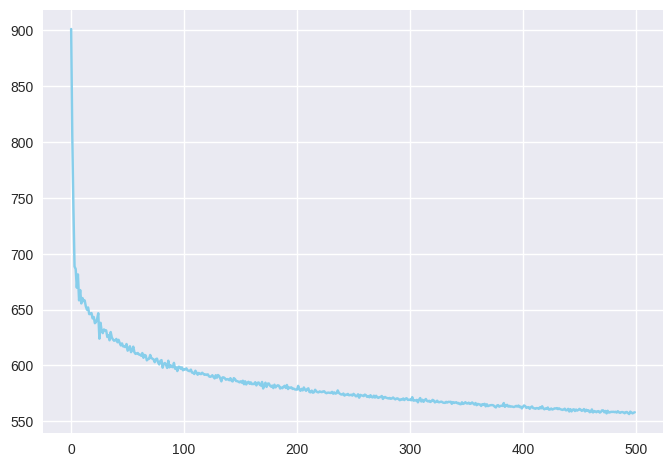

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")

model_training_history = {
    "epochs" : history.keys(),
    "loss" : [history[key].cpu().numpy() for key in history.keys()]
}
training_history = pd.DataFrame.from_dict(model_training_history)
training_history["loss"] = training_history["loss"].astype("float")
training_history["loss"].plot(color="skyblue")
# training_history

In [14]:
word = "model"
id_to_word = convert_id_to_word(vocabularies)
vector = one_hot_vector(vocabularies, word)
_, _, result = model.forward(torch.DoubleTensor([vector]).cuda())
result = result.cpu().numpy()[0]
print(np.argmax(result))
print(convert_prob_dist_to_word(result, id_to_word))

1478
training


In [15]:
for word in (id_to_word[id] for id in np.argsort(result)[::-1][:10]):
    print(word)

training
data
learning
model
algorithms
test
network
set
models
machine


In [16]:
model.save("/kaggle/working/model.pth")